## Sample Data


In [2]:
import numpy as np
from scipy.special import gamma
import random
from collections import Counter

import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
import gensim


In [6]:
import ete3

In [7]:
tokenizer = RegexpTokenizer(r'\w+')

# create English stop words list
en_stop = get_stop_words('en')

# Create p_stemmer of class PorterStemmer
p_stemmer = PorterStemmer()

# create sample documents
doc_a = "Batman became popular soon after his introduction and gained his own comic book title, Batman, in 1940."

doc_b = "In 1971, Trump moved to Manhattan, where he became involved in larger construction projects, and used attractive architectural design to win public recognition."

doc_c = "Batman is, in his everyday identity, Bruce Wayne, a wealthy American business magnate living in Gotham City."

doc_d = "In 2001, Trump completed Trump World Tower, a 72-story residential tower across from the United Nations Headquarters."

doc_e = " Unlike most superheroes, Batman does not possess any superpowers; rather, he relies on his genius intellect, physical prowess, martial arts abilities, detective skills, science and technology, vast wealth, intimidation, and indomitable will. "

# compile sample documents into a list
doc_set = [doc_a, doc_b, doc_c, doc_d, doc_e]

# list for tokenized documents in loop
texts = []

# loop through document list
for i in doc_set:

    # clean and tokenize document string
    raw = i.lower()
    tokens = tokenizer.tokenize(raw)

    # remove stop words from tokens
    stopped_tokens = [i for i in tokens if not i in en_stop]

    # stem tokens
    stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]

    # add tokens to list
    texts.append(stemmed_tokens)

## CRP

In [8]:
def CRP(topic, gamma):
    '''CRP gives the probability of topic assignment for specific vocabulary'''
    '''Return a j * 1 vector, where j is the number of topic'''
    cm = []
    m = sum([len(x) for x in topic])
    p = gamma / (gamma + m) # prob for new topic
    cm.append(p)
    for j in range(len(topic)):
        p = len(topic[j]) / (gamma + m) # prob for existing topics
        cm.append(p)
    return np.array(cm)

## node sampling

In [9]:
def node_sampling(corpus_s, gamma):
    '''Node sampling samples the number of topics for next level'''
    topic = []    
    for corpus in corpus_s:
        for doc in corpus:
            cm = CRP(topic, gamma)
            theta = np.random.multinomial(1, (cm/sum(cm))).argmax()
            if theta == 0:
                # create new topic
                topic.append([doc])
            else:
                # existing topic
                topic[theta-1].append(doc)
    return topic    
    

## Z
$P(z_{i}=j\hspace{1ex}|\hspace{1ex}{\bf z}_{-i},{\bf w})\propto\frac{n_{-i,j}^{(w_{i})}+\beta}{n_{-i,j}^{(\cdot)}+W\beta}\frac{n_{-i,j}^{(d_{i})}+\alpha}{n_{-i,\cdot}^{(d_{i})}+T\alpha}$

In [10]:
def Z(corpus_s, topic, alpha, beta):
    '''Z distributes each vocabulary to topics'''
    '''Return a n * 1 vector, where n is the number of vocabularies'''
    n_vocab = sum([len(x) for x in corpus_s])
    # zm: n * 1
    # return the assignment of each vocabulary
    t_zm = np.zeros(n_vocab).astype('int')
    # z_assigned: j * 1
    # return a list of list topic where stores assigned vocabularies in each sublist
    z_assigned = [[] for _ in topic]
    z_doc = [[] for _ in topic]
    z_tmp = np.zeros((n_vocab, len(topic)))
    assigned = np.zeros((len(corpus_s), len(topic)))
    n = 0
    for i in range(len(corpus_s)):
        for d in range(len(corpus_s[i])): 
            wi = corpus_s[i][d]   
            for j in range(len(topic)):
                lik = (z_assigned[j].count(wi) + beta) / (assigned[i, j] + n_vocab * beta)
                pri = (len(z_assigned[j]) + alpha) / ((len(corpus_s[i]) - 1) + len(topic) * alpha)
                z_tmp[n, j] = lik * pri
                t_zm[n] = np.random.multinomial(1, (z_tmp[n,:]/sum(z_tmp[n,:]))).argmax()
            z_assigned[t_zm[n]].append(wi)
            z_doc[t_zm[n]].append(i)
            assigned[i, t_zm[n]] += 1
            n += 1
    z_assigned = [x for x in z_assigned if x != []]
    z_doc = [x for x in z_doc if x != []]
    return np.array(z_assigned)

## C

In [11]:
def C(corpus_s, topic, gamma):
    cm = []
    for corpus in corpus_s:
        for word in corpus:
            for t in topic:
                if type(t) == list:
                    y = t.count(word)
                else:
                    y = t.tolist().count(word)
        H = np.random.poisson(lam=(2), size=(len(topic)))
        alpha = gamma*H
        temp = np.random.dirichlet(y + alpha).transpose()    
        cm.append((temp/sum(temp)).tolist())
    return np.array(cm)

## wn

In [12]:
most_common = lambda x: Counter(x).most_common(1)[0][0]
def wn(c_m, corpus_s, topic):
    wn_topic = []
    for i, corpus in enumerate(corpus_s):
        for word in corpus:
            theta = np.random.multinomial(1, c_m[i]).argmax()
            wn_topic.append(theta)
    return np.array(wn_topic)

            
def gibbs_wn(c_m, corpus_s, topic, ite):
    n_vocab = sum([len(x) for x in corpus_s])
    wn_gibbs = np.empty((n_vocab, ite)).astype('int')
    for i in range(ite):
        wn_gibbs[:, i] = wn(c_m, corpus_s, topic)
    # drop first 1/10 data
    wn_gibbs = wn_gibbs[:, int(ite/10):]
    theta = [most_common(wn_gibbs[x]) for x in range(n_vocab)]
    
    wn_topic = [[] for _ in topic]
    wn_doc_topic = [[] for _ in topic]
    doc = 0
    n = 0
    for i, corpus_s in enumerate(corpus_s):
        if doc == i:
            for word in corpus_s:
                wn_doc_topic[theta[n]].append(word)
                n += 1
            for j in range(len(topic)):
                if wn_doc_topic[j] != []:
                    wn_topic[j].append(wn_doc_topic[j])
        wn_doc_topic = [[] for _ in topic]        
        doc += 1
    wn_topic = [x for x in wn_topic if x != []]
    return wn_topic

## hLDA

In [314]:
def hLDA(corpus_s, gamma, alpha, beta, ite, level):
    
    # 1. Node sampling, samples max level L
    topic = node_sampling(corpus_s, gamma)
    
    def dis(corpus_s, gamma, alpha, beta, ite):
        
        # 2. z_m, samples topic from L
        z_topic = Z(corpus_s, topic, alpha, beta)
        
        # 3. c_m, samples path
        c_m = C(corpus_s, z_topic, gamma)
        
        # 4. w_n, distributes words into topics
        wn_topic = gibbs_wn(c_m, corpus_s, z_topic, ite)

        return wn_topic
    
    hLDA_tree = [[] for _ in range(level)]
    tmp_tree = []
    node = [[] for _ in range(level+1)]
    node[0].append(1)
    
    for i in range(level):
        if i == 0:
            wn_topic = dis(texts, gamma, alpha, beta, ite)
            topic = set([x for list in wn_topic[0] for x in list])
            hLDA_tree[0].append(topic)
            tmp_tree.append(wn_topic[1:])
            tmp_tree = tmp_tree[0]
            node[1].append(len(wn_topic[1:]))
        else:
            for j in range(sum(node[i])):
                if tmp_tree == []:
                    break
                wn_topic = dis(tmp_tree[0], gamma, alpha, beta, ite)
                topic = set([x for list in wn_topic[0] for x in list])
                hLDA_tree[i].append(topic)
                tmp_tree.remove(tmp_tree[0])
                if wn_topic[1:] != []:
                    tmp_tree.extend(wn_topic[1:])
                node[i+1].append(len(wn_topic[1:]))
        
    return hLDA_tree, node[:level]
    


In [545]:
ans = hLDA(texts, 5, 0.1, 0.01, 1000, 3)
ans

([[{'1971',
    '72',
    'architectur',
    'attract',
    'becam',
    'construct',
    'design',
    'involv',
    'larger',
    'manhattan',
    'move',
    'project',
    'public',
    'recognit',
    'trump',
    'use',
    'win'}],
  [{'2001',
    'across',
    'complet',
    'headquart',
    'nation',
    'residenti',
    'stori',
    'tower',
    'trump',
    'unit',
    'world'},
   {'1940', 'batman', 'becam', 'comic', 'gain', 'popular', 'soon', 'titl'},
   {'american', 'everyday', 'gotham', 'wayn'}],
  [{'introduct'},
   {'art',
    'batman',
    'detect',
    'intellect',
    'intimid',
    'martial',
    'reli',
    'scienc',
    'superpow',
    'technolog',
    'vast'},
   {'abil', 'geniu', 'skill', 'will'},
   {'batman',
    'book',
    'bruce',
    'busi',
    'citi',
    'ident',
    'live',
    'magnat',
    'wealthi'}]],
 [[1], [3], [0, 3, 1]])

In [546]:
words = ans[0]
struc = ans[1]

In [555]:
ls = ['a','b','c','d']
print(struc[2])
print(ls[:3])
print(ls[:1])

[0, 3, 1]
['a', 'b', 'c']
['a']


In [551]:
graph = pydot.Dot(graph_type='graph')
for level in range(len(struc)-1):
    
    leaf_level = level + 1
    leaf_word = words[leaf_level]
    leaf_struc = struc[leaf_level]

    word = words[level]
    for len_root in range(len(word)):
        root_word = '\n'.join(word[len_root])
        leaf_index = leaf_struc[len_root]
        #print(leaf_index)
        for idd in range(leaf_index):
            lf = leaf_word[idd]
            leaf_w = '\n'.join(lf) 
            edge = pydot.Edge(root_word, leaf_w)
            graph.add_edge(edge)
            if leaf_level == 2:
                print(lf)
    
    
    

{'introduct'}
{'detect', 'intimid', 'vast', 'art', 'superpow', 'martial', 'batman', 'reli', 'scienc', 'technolog', 'intellect'}
{'geniu', 'will', 'abil', 'skill'}
{'introduct'}


In [631]:
def HLDA_plot(hLDA_object):
    
    words = hLDA_object[0]
    struc = hLDA_object[1]
      
    graph = pydot.Dot(graph_type='graph')
    end_index = [np.insert(np.cumsum(i),0,0) for i in struc]
    for level in range(len(struc)-1):

        leaf_level = level + 1
        leaf_word = words[leaf_level]
        leaf_struc = struc[leaf_level]
        word = words[level]
        end_leaf_index = end_index[leaf_level]

        for len_root in range(len(word)):
            root_word = '\n'.join(word[len_root])
            leaf_index = leaf_struc[len_root]  
            start = end_leaf_index[len_root]
            end = end_leaf_index[len_root+1]
            lf = leaf_word[start:end]  
            for l in lf:
                leaf_w = '\n'.join(l) 
                edge = pydot.Edge(root_word, leaf_w)
                graph.add_edge(edge)
    viewPydot(graph)

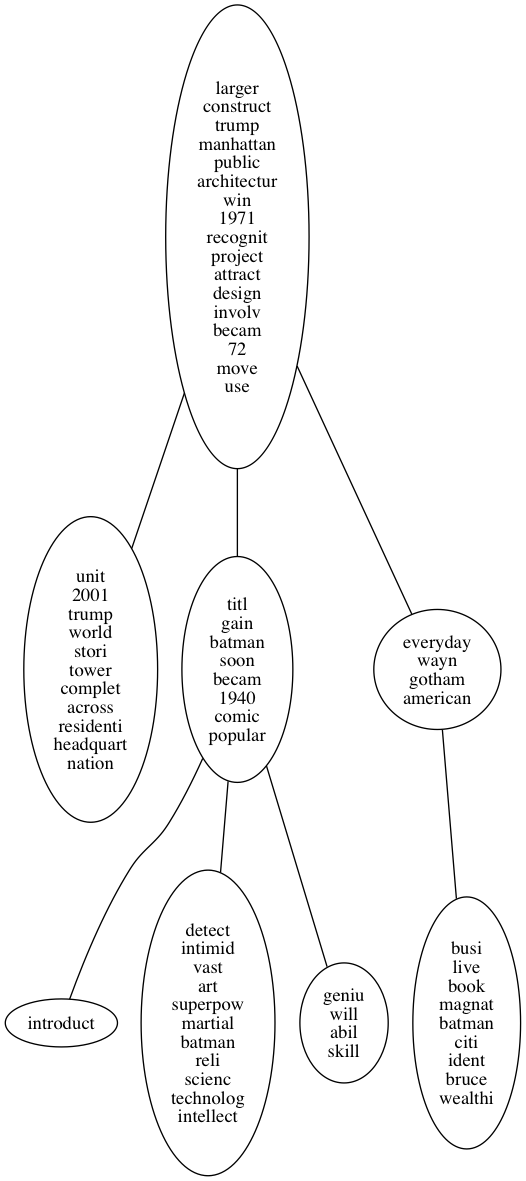

In [634]:
HLDA_plot(ans)

In [613]:
leaf_level = 2
end_index = [np.insert(np.cumsum(i),0,0) for i in struc]
end_leaf_index = end_index[leaf_level]
end_leaf_index

array([0, 0, 3, 4])

In [610]:
a = np.array([0, 3, 4])
np.insert(a,0,0)

array([0, 0, 3, 4])

In [580]:
map(struc, lambda x : np.cumsum(np.array(x)))

TypeError: 'function' object is not iterable

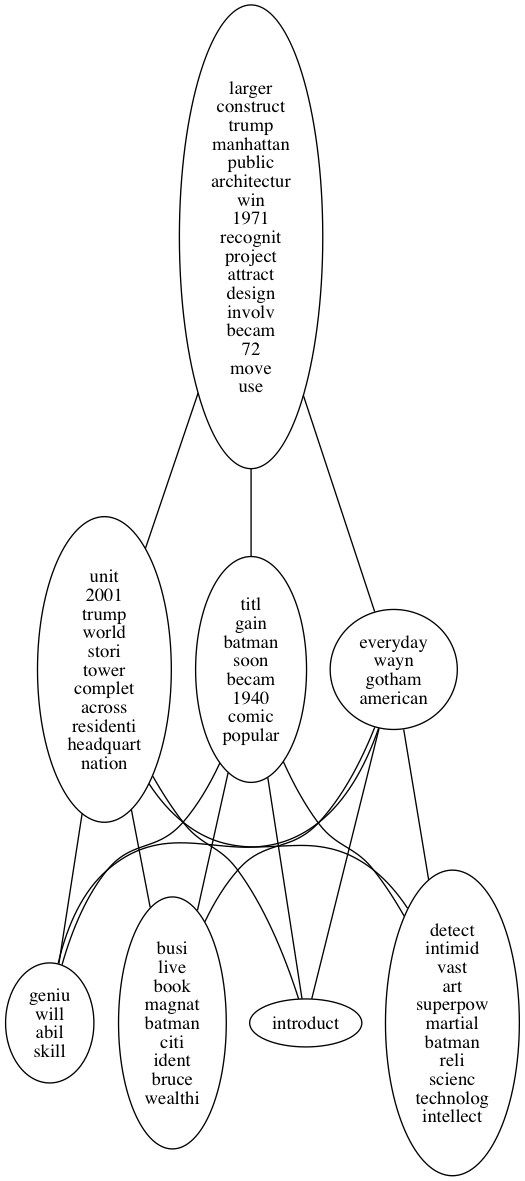

In [438]:
ls = [1,2,3,4,5,6,7,8,9]
print(ls)

[1, 2, 3, 4, 5, 6, 7, 8, 9]


In [440]:
del(ls[:4])
ls

[6, 7, 8, 9]

In [326]:
level = 1
word = words[level]
leaf_level = level + 1
leaf_word = words[leaf_level]
leaf_struc = struc[leaf_level]
for len_root in range(len(word)):
    root_word = '\n'.join(word[len_root])
    #print(root_word)
    print(leaf_word[:leaf_struc[len_root]])
    for l_w in leaf_word[:leaf_struc[len_root]]:
        L_W = '\n'.join(l_w)
        edge = pydot.Edge(root_word, leaf_word)
        graph.add_edge(edge)
         
        #leaf_word = leaf_word[:-leaf_struc[len_root]]   
            
            
        
        


[{'unit', '2001', 'trump', 'world', 'stori', 'tower', 'complet', 'across', '72', 'residenti', 'headquart', 'nation'}, {'busi', 'wayn', 'live', 'gotham', 'american', 'magnat', 'batman', 'everyday', 'citi', 'ident', 'bruce', 'wealthi'}]
{'unit', '2001', 'trump', 'world', 'stori', 'tower', 'complet', 'across', '72', 'residenti', 'headquart', 'nation'}
{'busi', 'wayn', 'live', 'gotham', 'american', 'magnat', 'batman', 'everyday', 'citi', 'ident', 'bruce', 'wealthi'}
[]


In [332]:
print(leaf_word)


[{'unit', '2001', 'trump', 'world', 'stori', 'tower', 'complet', 'across', '72', 'residenti', 'headquart', 'nation'}, {'busi', 'wayn', 'live', 'gotham', 'american', 'magnat', 'batman', 'everyday', 'citi', 'ident', 'bruce', 'wealthi'}]


In [214]:
for level in range(len(struc)-1):
    word = words[level]
    leaf_level = level + 1
    leaf_word = words[leaf_level]
    for len_root in range(len(word)):
        root_word = '\n'.join(word[len_root])
        
        
        
        
        


[{'larger', 'construct', 'trump', 'manhattan', 'public', 'architectur', 'win', '1971', 'recognit', 'project', 'attract', 'design', 'involv', 'becam', 'move', 'use'}]
[{'wealth', 'unlik', 'detect', 'vast', 'art', 'superpow', 'batman', 'physic', 'reli', 'prowess', 'geniu', 'abil', 'skill', 'intellect', 'will', 'superhero'}, {'book', 'batman', 'becam', '1940', 'introduct'}]
[{'titl', 'gain', 'batman', 'soon', 'comic', 'popular'}, {'busi', 'wayn', 'live', 'gotham', 'american', 'magnat', 'batman', 'everyday', 'citi', 'ident', 'bruce', 'wealthi'}, {'possess', 'unit', 'rather', '2001', 'technolog', 'trump', 'world', 'intimid', 'indomit', 'stori', 'tower', 'martial', 'complet', 'scienc', 'across', '72', 'residenti', 'headquart', 'nation'}]


In [ ]:
for node in range(0,struc[1][0]):
    leaf_word = '\n'.join(words[1][node])
    edge = pydot.Edge(root_word, leaf_word)
    graph.add_edge(edge)


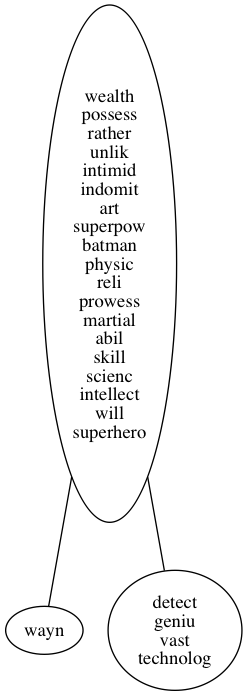

In [147]:
print(word[0][0])
a = '\n'.join(word[0][0])


{'busi', 'wayn', 'live', 'gotham', 'american', 'magnat', 'batman', 'everyday', 'citi', 'ident', 'bruce', 'wealthi'}


In [165]:
words[1]

[{'abil',
  'art',
  'batman',
  'detect',
  'geniu',
  'indomit',
  'intellect',
  'intimid',
  'martial',
  'physic',
  'possess',
  'prowess',
  'rather',
  'reli',
  'scienc',
  'skill',
  'superhero',
  'superpow',
  'technolog',
  'unlik',
  'vast',
  'wealth',
  'will'},
 {'1940',
  'batman',
  'becam',
  'book',
  'comic',
  'gain',
  'introduct',
  'popular',
  'soon',
  'titl'},
 {'1971',
  'architectur',
  'attract',
  'becam',
  'construct',
  'design',
  'involv',
  'larger',
  'manhattan',
  'move',
  'project',
  'public',
  'recognit',
  'trump',
  'use',
  'win'}]

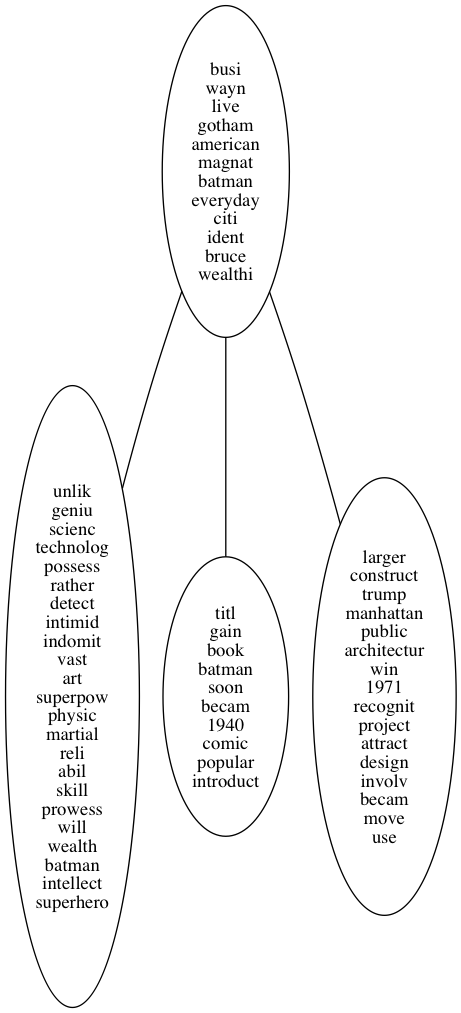

In [65]:
import pydot

In [80]:
graph = pydot.Dot(graph_type='graph')

In [ ]:
for i in range(3):
    
    edge = pydot.Edge("king", "lord%d" % i)
    # and we obviosuly need to add the edge to our graph
    graph.add_edge(edge)

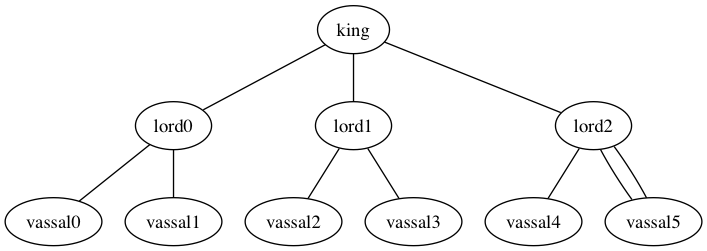

In [105]:
viewPydot(graph)

In [81]:


vassal_num = 0
for i in range(3):
    # we create new edges, now between our previous lords and the new vassals
    # let us create two vassals for each lord
    for j in range(2):
        edge = pydot.Edge("lord%d" % i, "vassal%d" % vassal_num)
        graph.add_edge(edge)
        vassal_num += 1

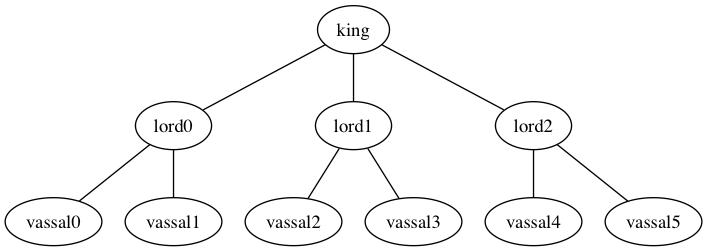

In [90]:
from IPython.display import Image, display
def viewPydot(pdot):
    plt = Image(pdot.create_png())
    display(plt)

viewPydot(graph)